### SUM MAIN RUN ExMAS


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy import optimize

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs

#### Prepare the input data

Set up the OTP API and define the parameters (such as average_speed, ticket_price, etc.) in the default_SUM.json file

In [7]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

When first time running the code, download and save the city graph

In [8]:
# inData = ExMAS.utils.download_G(inData, params)
# ExMAS.utils.save_G(inData, params)

Load the city graph

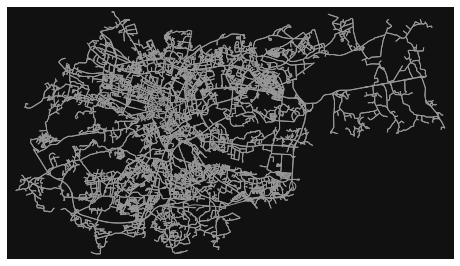

In [9]:
inData = ExMAS.utils.load_G(inData, params, stats=True)
fig, ax = ox.plot_graph(inData.G, node_size=0)

Read the files with data: city zones and their centroids

In [10]:
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

Read SUM areas and transform the coordinate system to EPSG:4326

<Axes: >

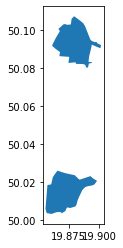

In [11]:
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
gdf_areas = gdf_areas.to_crs(4326) 
gdf_areas.plot()

In [12]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


Read ODMs, clean the data and calculate the "probabilities" for destinations

In [13]:
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

Read the population distribution of the city, clean the data

In [14]:
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

Define hub locations for each area

In [16]:
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

#### Run simulations

In [41]:
results = fncs.simulate(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, degree=6, N=30, ASC=2.3)

29-09-24 20:51:12-INFO-Initializing pairwise trip shareability between 211 and 211 trips.
29-09-24 20:51:12-INFO-creating combinations
29-09-24 20:51:12-INFO-44310	 nR*(nR-1)
29-09-24 20:51:12-INFO-Reduction of feasible pairs by 98.44%
29-09-24 20:51:12-INFO-Degree 2 	Completed
29-09-24 20:51:12-INFO-trips to extend at degree 2 : 1379
29-09-24 20:51:14-INFO-At degree 2 feasible extensions found out of 1043 searched
29-09-24 20:51:14-INFO-Degree 3 	Completed
29-09-24 20:51:14-INFO-trips to extend at degree 3 : 1043
29-09-24 20:51:15-INFO-At degree 3 feasible extensions found out of 1098 searched
29-09-24 20:51:15-INFO-Degree 4 	Completed
29-09-24 20:51:15-INFO-trips to extend at degree 4 : 1098
29-09-24 20:51:17-INFO-At degree 4 feasible extensions found out of 444 searched
29-09-24 20:51:17-INFO-Degree 5 	Completed
29-09-24 20:51:17-INFO-trips to extend at degree 5 : 444
29-09-24 20:51:17-INFO-At degree 5 feasible extensions found out of 48 searched
29-09-24 20:51:17-INFO-Degree 6 	Com

Save the [results](https://github.com/anniutina/SUM/tree/main/results)

In [43]:
results_b = results[0]['Bronowice Wielkie']
results_s = results[0]['Skotniki']
results_b.to_csv("results/bronowice_exmas_30.csv")
results_s.to_csv("results/skotniki_exmas_30.csv")

Results of 30 iterations for Bronowice Wielkie area

In [42]:
# mean values of the selected parameters
results[0]['Bronowice Wielkie']

,tw_PT_OD,tw_PT_HD,u_PT_OD,u_PT_HD,u_SUM_OD,p_SUM
0,128.466667,54.095238,13.757178,10.337935,16.270895,0.281675
1,150.261905,64.271429,13.917733,10.624183,16.528026,0.326104
2,91.608491,50.495283,13.094119,10.285202,16.194357,0.238505
3,111.009569,56.277512,13.212084,10.083533,15.840038,0.341442
4,107.473430,53.990338,13.077229,10.010248,15.932429,0.261412
5,135.418269,60.716346,13.656377,10.374594,16.313940,0.308030
6,111.389423,48.966346,13.158962,10.092945,16.114751,0.313038
7,166.823810,62.138095,14.144115,10.755493,16.659732,0.295265
8,124.129808,53.418269,13.588691,10.212657,16.152118,0.223646
9,128.516588,66.341232,13.524253,10.707021,16.702427,0.154262


In [34]:
# results of 1 iteration
df_sum_b = results[1]["Bronowice Wielkie"]
df_sum_b

,origin_x,origin_y,destination_x,destination_y,treq,u_PT_OD,origin,hub,dist,ttrav,tarr,u,u_PT_HD,u_SUM_OD,p_SUM
0,19.882765,50.104112,20.017170,50.076269,2024-03-28 08:07:12,19.096058,933716014,1786358199,2892,482.000000,2024-03-28 08:15:14,5.784,13.559814,21.923814,0.055843
1,19.881693,50.086188,19.896750,50.092024,2024-03-28 08:14:32,9.16263,232660185,1786358199,641,106.833333,2024-03-28 08:16:18,1.282,6.762837,10.624837,0.188130
2,19.889108,50.095237,19.935630,50.087582,2024-03-28 07:51:16,7.947208,264718166,1786358199,2492,415.333333,2024-03-28 07:58:11,4.984,7.435874,14.999874,0.000864
3,19.884926,50.100981,19.896750,50.092024,2024-03-28 08:07:55,6.370549,264718170,1786358199,2461,410.166667,2024-03-28 08:14:45,4.922,6.762837,14.264837,0.000373
4,19.879642,50.096373,19.984857,50.087964,2024-03-28 08:02:33,18.02071,3830945443,1786358199,2218,369.666667,2024-03-28 08:08:42,4.436,9.018741,16.034741,0.879316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,19.869071,50.098383,19.909705,50.071701,2024-03-28 08:00:57,8.965832,267567174,1786358199,2455,409.166667,2024-03-28 08:07:46,4.910,10.458273,17.948273,0.000126
201,19.872702,50.100578,19.905667,50.093114,2024-03-28 07:51:08,15.473119,1710281870,1786358199,2777,462.833333,2024-03-28 07:58:50,5.554,9.774307,17.908307,0.080528
202,19.885622,50.084549,19.952185,50.025729,2024-03-28 07:51:06,12.650705,4263449095,1786358199,1897,316.166667,2024-03-28 07:56:22,3.794,15.459876,21.833876,0.000103
203,19.885483,50.092189,19.965454,50.090546,2024-03-28 07:50:21,14.495655,2397235539,1786358199,1509,251.500000,2024-03-28 07:54:32,3.018,5.702891,11.300891,0.960637
